In [1]:
import sys
import copy
import math
import pickle

sys.path.append("../../")

import numpy as np
import torch
import matplotlib.pyplot as plt

import implicitmodules.torch as dm

torch.set_default_tensor_type(torch.FloatTensor)

In [26]:
def sample(pts_silent, pts_implicit1, R, C, sigma):
    while True:
        # We first pick a random index in pts_silent and get the normal position
        # We substract 1 to the possible index so we can easily get the tangent vector
        # ind = np.asscalar(np.random.choice(pts_silent.shape[0] - 1, 1))
        # tan = (pts_silent[ind + 1] - pts_silent[ind]).numpy()
        # norm = np.array([tan[1], -tan[0]])
        # norm /= np.linalg.norm(norm)
        # norm *= -150.
        # cotan = torch.zeros_like(pts_silent)
        # cotan[ind] = torch.tensor(norm)

        #cotan = 20.*torch.randn_like(pts_silent)
        cotan = 10.*torch.randn_like(pts_silent)
        #cotan = torch.zeros_like(pts_silent)
        # cotan[:10, 0] = -10.
        # cotan[120:130, 0] = -10.
        #cotan[pts_silent[:, 0] <= 0, 0] = -2.

        # val_left = -1.
        # val_right = 1.
        # cotan[30:39, 1] = val_left
        # cotan[212:221, 1] = -val_left
        # cotan[92:101, 1] = val_right
        # cotan[149:158, 1] = -val_right

        # plt.plot(pts_silent[:, 0].numpy(), pts_silent[:, 1].numpy())
        # plt.quiver(pts_silent[:, 0].numpy(), pts_silent[:, 1].numpy(), cotan[:, 0].numpy(), cotan[:, 1].numpy())
        # plt.show()

        silent = dm.DeformationModules.SilentLandmarks.build_from_points(pts_silent)
        silent.manifold.fill_cotan(cotan.view(-1).requires_grad_())
        # implicit1 = dm.DeformationModules.ImplicitModule1.build_and_fill(2, pts_implicit1.shape[0], C[:, :, 0].unsqueeze(2), sigma, 0.001, gd=(pts_implicit1.view(-1).requires_grad_(), R.view(-1).requires_grad_()))
        # implicit1_2 = dm.DeformationModules.ImplicitModule1.build_and_fill(2, pts_implicit1.shape[0], C[:, :, 1].unsqueeze(2), sigma, 0.001, gd=(pts_implicit1.view(-1).requires_grad_(), R.view(-1).requires_grad_()))
        implicit1 = dm.DeformationModules.ImplicitModule1.build_and_fill(2, pts_implicit1.shape[0], C, sigma, 0.001, gd=(pts_implicit1.view(-1).requires_grad_(), R.view(-1).requires_grad_()))
        with torch.autograd.no_grad():
            dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian([silent, implicit1]), 100, 'euler')
            sample = silent.manifold.gd.detach().view(-1, 2)
            sample = sample - torch.mean(sample, dim=0)
            print(torch.norm(sample).item())
        if torch.norm(sample).item() > 100. or torch.norm(sample).item() < 5. or math.isnan(torch.norm(sample).item()):
            continue
        else:
            return sample

In [31]:
n_pts = 200
vertical_scaling = 2.
ellipse = torch.stack([torch.cos(torch.linspace(0., 2.*math.pi, n_pts)),
                     vertical_scaling*torch.sin(torch.linspace(0., 2.*math.pi, n_pts))], dim=1)

aabb_ellipse = dm.Utilities.AABB.build_from_points(ellipse)

density = 30
print(3./math.sqrt(density))

pts_implicit1 = dm.Utilities.fill_aabb(aabb_ellipse, density)

0.5477225575051661


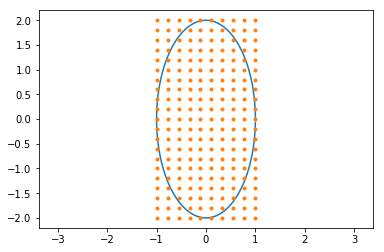

In [4]:
plt.plot(ellipse.numpy()[:-1, 0], ellipse.numpy()[:-1, 1])
plt.plot(pts_implicit1.numpy()[:, 0], pts_implicit1.numpy()[:, 1], '.')
plt.axis('equal')
plt.show()

In [5]:
C = torch.ones(pts_implicit1.shape[0], 2, 2)
C[:, 1 , 0] = torch.linspace(0., 10., pts_implicit1.shape[0])
C[:, 0, 0] = 0.

In [6]:
%matplotlib qt5
ax_left = plt.subplot(1, 2, 1)
dm.Utilities.plot_C_ellipse(ax_left, pts_implicit1, C, c_index=0, scale=0.1, color='red')
dm.Utilities.plot_C_arrow(ax_left, pts_implicit1, C, c_index=0, scale=0.1, color='black', zorder=3, mutation_scale=10)
plt.axis(aabb_ellipse.get_list())
plt.axis('equal')

ax_right = plt.subplot(1, 2, 2)
dm.Utilities.plot_C_ellipse(ax_right, pts_implicit1, C, c_index=1, scale=0.1, color='blue')
dm.Utilities.plot_C_arrow(ax_right, pts_implicit1, C, c_index=1, scale=0.1, color='black', zorder=3, mutation_scale=10)
plt.axis(aabb_ellipse.get_list())
plt.axis('equal')

plt.show()

In [6]:
angles = 0. * math.pi * torch.ones(pts_implicit1.shape[0])
R = torch.stack([dm.Utilities.rot2d(a) for a in angles])

tensor(79.4933)


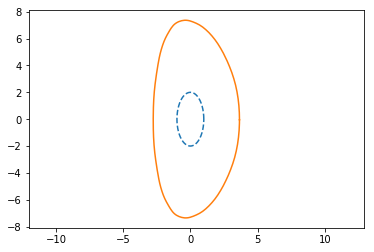

In [14]:
my_sample = sample(ellipse, pts_implicit1, R, C, 3./math.sqrt(density))

ax = plt.subplot()
plt.plot(ellipse[:, 0].numpy(), ellipse[:, 1].numpy(), '--')
plt.plot(my_sample[:, 0].numpy(), my_sample[:, 1].numpy())
plt.axis(aabb_ellipse.get_list())
plt.axis('equal')
plt.show()

In [27]:
sample_count = 50
samples = [ellipse.tolist()]
for i in range(sample_count):
    print("Generating sample", i)
    samples.append(sample(ellipse, pts_implicit1, R, C, 3./math.sqrt(density)).tolist())

Generating sample 0


0.01656300202012062


0.0011073910864070058


35141.55078125


10639.71875


27.23874855041504
Generating sample 1


0.02178795449435711


64.72570037841797
Generating sample 2


0.3202396035194397


66.54676055908203
Generating sample 3


0.4245466887950897


1267.515625


9.138407707214355
Generating sample 4


4022.76025390625


87.52510833740234
Generating sample 5


59.109474182128906
Generating sample 6


41.312835693359375
Generating sample 7


0.0014850171282887459


0.1663268655538559


0.1691848635673523


48.56036376953125
Generating sample 8


0.2952832579612732


57.6137809753418
Generating sample 9


3656.42236328125


3.744847297668457


33.83838653564453
Generating sample 10


12518.908203125


0.00032772106351330876


3.7075629234313965


1747.1368408203125


12626.8115234375


0.0044031706638634205


51.514915466308594
Generating sample 11


0.20774728059768677


0.0004294133686926216


0.0002545526949688792


25.93105697631836
Generating sample 12


58.98122787475586
Generating sample 13


22.597190856933594
Generating sample 14


73.04664611816406
Generating sample 15


11510.142578125


0.09324060380458832


0.030174503102898598


91907.4140625


0.5523930788040161


8.125295639038086
Generating sample 16


43.03446960449219
Generating sample 17


4.761665877595078e-06


0.012085792608559132


70.95081329345703
Generating sample 18


59.16256332397461
Generating sample 19


362181.46875


0.03923823684453964


32.114723205566406
Generating sample 20


19.110689163208008
Generating sample 21


10828.884765625


0.0002792751765809953


0.0034205992706120014


69.07671356201172
Generating sample 22


0.006322016939520836


0.003533953567966819


51850.77734375


3.654070724223857e-06


73115.734375


0.0009663755190558732


5.101847636979073e-05


0.02030056156218052


0.00031631358433514833


nan


83.21537017822266
Generating sample 23


0.5044904351234436


55164.90625


0.04205242916941643


0.10283834487199783


4863.95654296875


3271049.75


77116.1171875


14.181546211242676
Generating sample 24


0.08322935551404953


18.231046676635742
Generating sample 25


3.087181329727173


0.009596382267773151


1921.9659423828125


50.28788375854492
Generating sample 26


0.005965875927358866


0.0051692770794034


6.709183692932129
Generating sample 27


0.5162622928619385


57.305782318115234
Generating sample 28


15.95992374420166
Generating sample 29


44.833045959472656
Generating sample 30


0.0004344056360423565


29.15513801574707
Generating sample 31


51355.00390625


0.015088736079633236


0.05959319695830345


4.150113454670645e-05


8622.7568359375


0.04839175567030907


0.02209341526031494


193633.890625


0.009748974815011024


0.16630952060222626


20441.767578125


0.00012978989980183542


75.13424682617188
Generating sample 32


12525.248046875


44.966922760009766
Generating sample 33


24.52756690979004
Generating sample 34


53.96980667114258
Generating sample 35


0.0032323964405804873


0.009897217154502869


44.93631362915039
Generating sample 36


0.025663914158940315


0.008442871272563934


0.010023082606494427


0.02430405095219612


0.00993769709020853


74.67678833007812
Generating sample 37


0.745245099067688


0.0007081736694090068


0.00014521948469337076


0.02429959364235401


0.046851322054862976


33.806819915771484
Generating sample 38


29.866092681884766
Generating sample 39


20273.236328125


78.88045501708984
Generating sample 40


10.504556655883789
Generating sample 41


56.45634078979492
Generating sample 42


0.00044068379793316126


0.00492836581543088


8.75330988492351e-06


17770.01171875


45.861717224121094
Generating sample 43


0.006248823832720518


0.014737200923264027


0.01656496524810791


1.8496898412704468


74.65302276611328
Generating sample 44


39.87601852416992
Generating sample 45


0.007808443624526262


0.004453431349247694


3.387852191925049


0.013079920783638954


0.04646458849310875


287348.8125


7653.61474609375


12368.47265625


76.46651458740234
Generating sample 46


27.184511184692383
Generating sample 47


76259.796875


0.00770861329510808


1.2826648950576782


7.197234153747559
Generating sample 48


0.0011941073462367058


0.004896028898656368


3472.37353515625


5.347700607671868e-06


42272.66015625


69.37015533447266
Generating sample 49


87.42398834228516


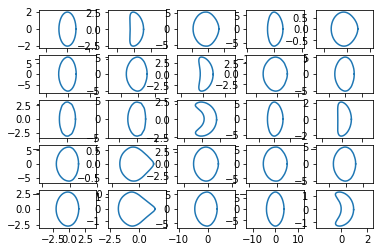

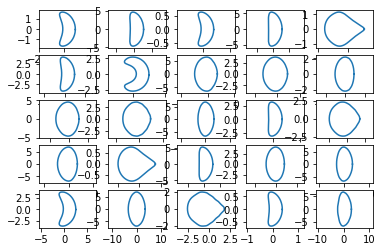

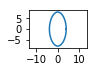

In [28]:
# Does not work somehow

nb_plot_row = 5
nb_plot_col = 5
cur_plot_index = 0
cont = True
while cont:
    for i in range(nb_plot_row):
        for j in range(nb_plot_col):
            if cur_plot_index < len(samples):
                plt.subplot(nb_plot_row, nb_plot_col, nb_plot_row*i+j+1)
                plt.axis(aabb_ellipse.get_list())
                plt.axis('equal')
                plt.plot(np.asarray(samples[cur_plot_index])[:, 0], np.asarray(samples[cur_plot_index])[:, 1])
                cur_plot_index = cur_plot_index + 1
            else:
                plt.show()
                cont = False
                break

    plt.show()        

In [30]:
pickle.dump({'c_gt_pos': pts_implicit1, 'c_gt': C, 'dataset': samples}, open("../../data/deformed_ellipses.pkl", 'wb'))